In [1]:
from helper.dataset_reader import read_tsv
from helper.data_transformer import *
from helper.utils import *
from langid_crf import *
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn_crfsuite import metrics

In [2]:
langid = LanguageIdentifier()

In [3]:
merged_data = read_tsv('../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../dataset/train.tsv')
val_data = read_tsv('../dataset/val.tsv')
test_data = read_tsv('../dataset/test.tsv')

In [4]:
train_data = to_token_tag_list(train_data)
val_data = to_token_tag_list(val_data)
test_data = to_token_tag_list(test_data)

In [5]:
def get_features(data):
	X = [langid.sent2features(s) for s in data]
	y = [langid.sent2tags(s) for s in data]

	return X, y

In [6]:
X_train, y_train = get_features(train_data)
X_val, y_val = get_features(val_data)
X_test, y_test = get_features(test_data)

In [7]:
print(f"Train set: {len(X_train)} sentences")
print(f"Val set: {len(X_val)} sentences")
print(f"Test set: {len(X_test)} sentences")

Train set: 2890 sentences
Val set: 723 sentences
Test set: 1781 sentences


### CRF Training

In [8]:
model = sklearn_crfsuite.CRF(
	algorithm='lbfgs',
	max_iterations=100,
	all_possible_transitions=True,
	c1=0.016119422903376198,  # Coefficient for Lasso (L1) regularization for
    c2=0.05918362699721527,  # Coefficient for Ridge (L2) regularization
)

In [9]:
# train CRF
%time
model.fit(X=X_train, y=y_train, X_dev=X_val, y_dev=y_val)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.016119422903376198,
    c2=0.05918362699721527, keep_tempfiles=None, max_iterations=100)

In [10]:
y_pred = model.predict(X_test)

In [11]:
# save model
model_name = 'crf_model_split.pkl'
root_path = 'model/'
joined_path = os.path.join(root_path, model_name)
pickle.dump(model, open(joined_path, 'wb'))


 Evaluation on the test data
Confusion Matrix
              precision    recall  f1-score   support

          ID       0.95      0.97      0.96     22314
          JV       0.91      0.92      0.91      4914
          EN       0.93      0.92      0.92      5017
   MIX-ID-EN       0.96      0.90      0.93       973
   MIX-ID-JV       0.96      0.88      0.92       280
   MIX-JV-EN       0.94      0.87      0.90       277
           O       0.96      0.92      0.94     10163

    accuracy                           0.95     43938
   macro avg       0.94      0.91      0.93     43938
weighted avg       0.95      0.95      0.95     43938



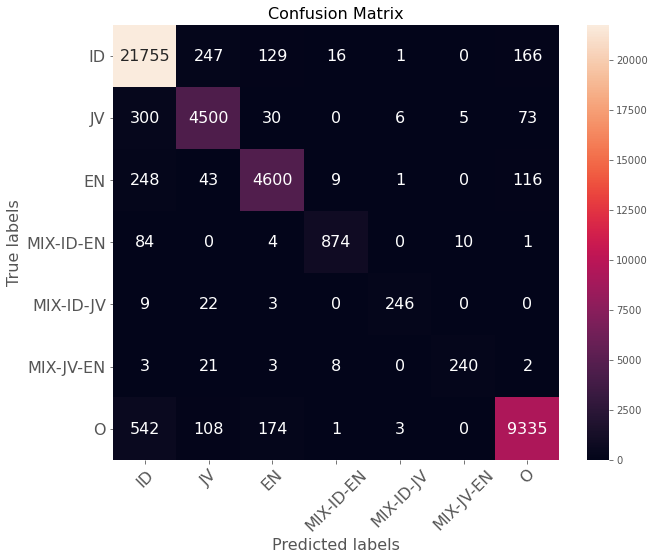

In [12]:
print('\n Evaluation on the test data')
langid.show_confusion_matrix(y_test, y_pred)

# increase font of x and y axis

In [13]:
print("\nTop likely transitions:")
langid.print_transitions(Counter(model.transition_features_).most_common(20))
print("\nTop unlikely transitions:")
langid.print_transitions(Counter(model.transition_features_).most_common()[-20:])

# check the state features
print("\nTop positive:")
langid.print_state_features(Counter(model.state_features_).most_common(20))
print("\nTop negative:")
langid.print_state_features(Counter(model.state_features_).most_common()[-20:])


Top likely transitions:
JV         -> O          1.00843
O          -> O          1.00787
EN         -> O          0.99575
ID         -> O          0.89811
O          -> JV         0.71502
EN         -> EN         0.66432
JV         -> JV         0.64248
O          -> ID         0.58140
O          -> EN         0.47823
ID         -> ID         0.23267
JV         -> MIX-ID-JV  0.06546
MIX-ID-JV  -> O          0.03939
EN         -> ID         0.03165
JV         -> MIX-JV-EN  -0.02149
ID         -> EN         -0.04068
MIX-ID-EN  -> O          -0.11685
JV         -> ID         -0.14475
JV         -> EN         -0.15216
MIX-JV-EN  -> O          -0.17690
EN         -> JV         -0.23395

Top unlikely transitions:
EN         -> MIX-ID-EN  -0.39213
MIX-JV-EN  -> EN         -0.41052
O          -> MIX-ID-JV  -0.45145
MIX-ID-JV  -> ID         -0.47008
MIX-ID-JV  -> EN         -0.63038
O          -> MIX-JV-EN  -0.63669
MIX-ID-JV  -> MIX-JV-EN  -0.66932
MIX-ID-EN  -> MIX-ID-EN  -0.72425
MIX-JV-EN

In [14]:
import eli5

eli5.show_weights(model,horizontal_layout=False, show=['transition_features'])

From \ To,EN,ID,JV,MIX-ID-EN,MIX-ID-JV,MIX-JV-EN,O
EN,0.664,0.032,-0.234,-0.392,-1.257,-0.358,0.996
ID,-0.041,0.233,-0.247,-0.382,-0.311,-1.152,0.898
JV,-0.152,-0.145,0.642,-1.431,0.065,-0.021,1.008
MIX-ID-EN,-0.284,-0.38,-1.287,-0.724,-0.93,-1.603,-0.117
MIX-ID-JV,-0.63,-0.47,-0.263,-2.33,-1.178,-0.669,0.039
MIX-JV-EN,-0.411,-1.006,-0.295,-0.867,-1.114,-0.861,-0.177
O,0.478,0.581,0.715,-0.285,-0.451,-0.637,1.008


In [15]:
eli5.show_weights(model, targets=['ID','EN','JV'])

In [16]:
eli5.show_weights(model, targets=['MIX-ID-EN','MIX-ID-JV','MIX-JV-EN','O'])

In [15]:
## Error Analysis
crf_model = pickle.load(open('model/crf_model.pkl','rb'))